# Analysis notebook
Author: Evan Azevedo  
Company: Amberdata  
Blog Post: Large Txn's in the Mempool

In [2]:
# loading the packages
import os
import json
import requests
from datetime import datetime, timedelta, timezone
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dotenv import load_dotenv

In [17]:
# helper functions
def get_key():
    "Get the API key from an .env file"
    if ".env" not in os.listdir("../"):
        print("Configuring API Key...")
        key = input("Amberdata API Key: ")
        with open("../.env", "w") as f:
            f.write(f"AMBERDATA_API_KEY={key}\n")
    load_dotenv(verbose=True)
    return {
        "AMBERDATA_API_KEY": os.getenv("AMBERDATA_API_KEY")
    }

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    try:
        if response["title"] == "OK":
            return response["payload"]
    except Exception as e:
        print(e)
        return None

# let's load our api key
api_key = get_key()

## Reading the data
Now we get to read in the data from our Raspberry Pi. For now I am just plotting the raw values to see what kind of volume of transactions are going on.

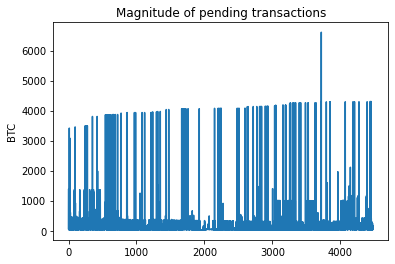

In [67]:
# read in the data from different sources
results = pd.read_csv("../data/results_08-14_08-15.csv", sep='; ', engine='python')

# get the value of BTC per pending txn
results["btc"] = results.value // 10**8
# convert to timestamp
results['timestamp'] = pd.to_datetime(results.timestamp, utc=True)

# plot just to see if there are lots of whale activity
results.btc.plot()
plt.title("Magnitude of pending transactions")
plt.ylabel("BTC")
plt.savefig("../plots/mag_pending.png")
plt.show()

## Getting OHLCV data

In [10]:
dfs = []
n_days = 5

for i in range(n_days):
    print(f"Iteration: {i}")
    # get the start and end dates in timestamps
    startDate = results.timestamp.min() + timedelta(i-1)
    endDate = startDate + timedelta(1)
    
    # convert to UNIX format
    startDate = str(round(startDate.timestamp()*10**3))
    endDate = str(round(endDate.timestamp()*10**3))

    # the url for our endpoint
    url = "https://web3api.io/api/v2/market/ohlcv/btc_usd/historical"
    
    # our query
    querystring = {
        "timeInterval": "minutes", 
        "timeFormat": "iso",
        'startDate': startDate, 
        'endDate': endDate, 
        "exchange": "bitfinex"
    }
    
    # the API key
    headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}

    # the response for our query
    payload = get_response(url, headers, querystring)
    
    # we save the OHLCV data
    bfx = payload['data']['bitfinex']

    # get the columns and make a dataframe
    columns = payload['metadata']['columns']
    bfx_df = pd.DataFrame(bfx, columns=columns)
    # append the dataframe to a list
    dfs.append(bfx_df)

# combine the several days of OHLCV data
ohlcv = pd.concat(dfs)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [13]:
# save current data to csv
ohlcv.to_csv("../data/ohlcv.csv", index=False)
results.to_csv("../data/results_all_08-14_08-15.csv", index=False)

## Working with the OHLCV data

In [7]:
# read the data from our saved csvs
ohlcv = pd.read_csv("../data/ohlcv.csv")
results = pd.read_csv("../data/results_all_08-14_08-15.csv")

# change the UNIX timestamp to human readable format and set it as index
results["timestamp"] = pd.to_datetime(results.timestamp, utc=True)

# unify the timestamp format and set as index
ohlcv["timestamp"] = pd.to_datetime(ohlcv.timestamp)

# drop OHL from the dataframe
ohlcv.drop(['open', 'high', 'low'], axis=1, inplace=True)

# select only data from our date range
ohlcv = ohlcv[(ohlcv.timestamp <= results.timestamp.max()) & (ohlcv.timestamp >= results.timestamp.min())]

# set timestamp as index
ohlcv.set_index("timestamp", inplace=True)

### Adding USD to Pending txns
We would like to add the value of Bitcoin to our results DataFrame, so we can see the value of the transactions in USD.

In [10]:
# add a column of timestamps rounded to the minute
results["ts_minute"] = results.timestamp.dt.round('1min')

# rename the ohlcv column for joining
ohlcv_min = ohlcv.reset_index().rename({"timestamp": "ts_minute"}, axis=1)

# join the close column to the results dataframe
df_merged = pd.merge(results, ohlcv_min, on = "ts_minute", how='left').dropna()

# create the usd value column
df_merged["usd"] = df_merged.value/10**8 * df_merged.close


# display the result, sorted by the largest transactions
# sort the values by increasing dollar amounts
data_sorted = df_merged.sort_values("usd", ascending=False)
# display the top n transactions
n_txn = 10       # the number of the top transactions we want to focus on
data_sorted.head(n_txn)

,timestamp,from,to,hash,value,btc,ts_minute,close,volume,usd
3722,2020-08-15 04:16:31.115861+00:00,['3LCGsSmfr24demGvriN4e3ft8wEcDuHFqh'],"['bc1qvx4ara9g7jfcucz7s3k43wk6hma363l0e54vdd',...",9dfea698d9babb7c4826ce947f53b9395bd31848ea7081...,660999304207,6609,2020-08-15 04:17:00+00:00,11863.000000,2.656826,7.841435e+07
4211,2020-08-15 06:18:02.676154+00:00,"['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '3A3EVW...",['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6'],95c6dd88b9507c5df95755e05153cd5960869562a0dada...,429319364572,4293,2020-08-15 06:18:00+00:00,11937.000000,1.928302,5.124785e+07
4442,2020-08-15 06:56:03.379047+00:00,"['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '3NjGhj...",['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6'],c6330e0299611ab6d6f0d685ba826f2dc20b5bf5dcd922...,430319224572,4303,2020-08-15 06:56:00+00:00,11905.170752,1.396340,5.123024e+07
4189,2020-08-15 06:14:08.981975+00:00,"['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '3A3EVW...",['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6'],95c6dd88b9507c5df95755e05153cd5960869562a0dada...,429319364572,4293,2020-08-15 06:14:00+00:00,11912.000000,1.530417,5.114052e+07
3852,2020-08-15 04:57:02.223934+00:00,"['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '34amkx...",['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6'],6eb4851a0dfadac9f7cd6b20414ecc58bcb357b6960ccb...,429227544572,4292,2020-08-15 04:57:00+00:00,11877.933218,0.010000,5.098336e+07
3850,2020-08-15 04:54:33.683976+00:00,"['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '34amkx...",['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6'],6eb4851a0dfadac9f7cd6b20414ecc58bcb357b6960ccb...,429227544572,4292,2020-08-15 04:55:00+00:00,11874.000000,0.524571,5.096648e+07
3398,2020-08-15 03:04:29.922460+00:00,['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6'],"['19ZamLaqCCXa2rvVeKcJPYWXBwXVMxy4zi', '19iqYb...",dfd04d52635e00c0f28fd1926c26f120d5acca6cf47610...,426274270244,4262,2020-08-15 03:04:00+00:00,11917.000000,5.339089,5.079910e+07
3314,2020-08-15 02:47:06.831047+00:00,"['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '3NdsXD...",['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6'],339bf3cd371075fb60c7b0785356c55874513cd56f7279...,425675725784,4256,2020-08-15 02:47:00+00:00,11916.000000,1.446488,5.072352e+07
3716,2020-08-15 04:15:27.476662+00:00,"['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '3LcZjE...",['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6'],6c44966bd217bb822affb46d9f6dcf4aea74736cb943ef...,427626983772,4276,2020-08-15 04:15:00+00:00,11861.000000,10.664353,5.072084e+07
3310,2020-08-15 02:45:01.294262+00:00,"['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '33svB3...",['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6'],d54442f4abcc602062dd93076348c6efea62e270137f16...,425665795784,4256,2020-08-15 02:45:00+00:00,11911.000000,0.490895,5.070105e+07


So there was one transaction that was significantly $(> 1/3)$ larger than the rest, for 6609 BTC. It was also only from a single sender: `3LCGsSmfr24demGvriN4e3ft8wEcDuHFqh`.

## Plotting whale activity on price

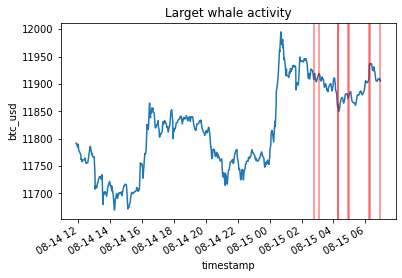

In [11]:
# plotting the time series of bitcoin price
#ohlcv.set_index("timestamp", inplace=True)
ohlcv.close.plot()

# add a red line when a large pending transaction occured
for i in range(n_txn-1):
    plt.axvline(data_sorted.iloc[i, 0], color='r', alpha=0.5)

plt.title("Larget whale activity")
plt.ylabel("btc_usd")
plt.show()

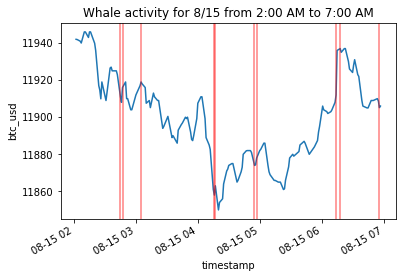

In [12]:
# the start and end of large whale activity
start, end = datetime(2020, 8, 15, 2, 0, 0, tzinfo=pytz.UTC), datetime(2020, 8, 15, 7, 0, 0, tzinfo=pytz.UTC)

# plotting the large whale activity
ohlcv[(ohlcv.index > start) & (ohlcv.index < end)].close.plot()

# adding red lines for when whale transactions where posted
for i in range(n_txn):
    # grabbing the timestamp in minutes
    ts = data_sorted.iloc[i, 0]
    # plotting the vertical line
    if ts > start and ts < end:
        plt.axvline(ts, color='r', alpha=0.5)
    
# add an appropriate title
plt.title(f"Whale activity for {start.month}/{start.day} from {start.hour}:{start.minute}0 AM to {end.hour}:{end.minute}0 AM")\
# label the y axis
plt.ylabel("btc_usd")
# save the figure
plt.savefig("../plots/whale_zoom_in.png")

## Zooming in to the effect of large transactions

In [13]:
# make a column in ohlcv data if there was a top transaction
ohlcv["top_txn"] = ohlcv.index.isin(data_sorted.head(n_txn).ts_minute)

In [14]:
i = 0              # initializing i
win_size = 7       # the window size after a large txn
windows = []       # an array for saving our windows

# iterate through the ohlcv data
while i <= len(ohlcv):
    # if the transaction is a large transaction
    if ohlcv.iloc[i, -1] == True:
        # save the txn and the minutes after
        windows.append(ohlcv.iloc[i:i+win_size])
        # increment the window to move past the current frame
        i += win_size - 1
    # increment the window normally
    i += 1

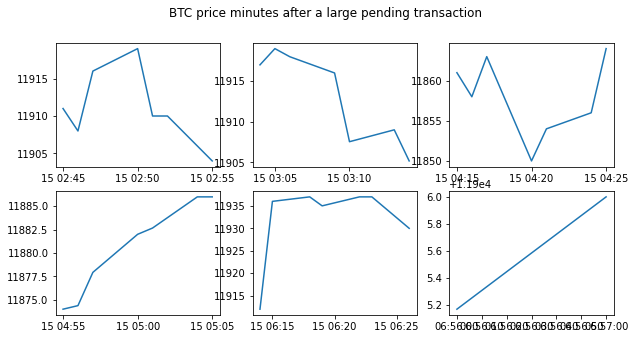

In [15]:
# let's plot each of the windows
# making the subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# 
for i, win in enumerate(windows):
    if i < 3:
        axs[0][i].plot(win.close)
    else:
        axs[1][i-3].plot(win.close)
        
fig.suptitle("BTC price minutes after a large pending transaction")
plt.show()

How many had a drop in price? Only transactions 1 and 3 had a perceptible drop in price after the first point. 

## Which Txn's went through?
Let's see first if our big $(>\$78 m)$ transaction went through. We can check this easily enough since we recorded the transaction hash, the timestamp, and the address as well as the transaction size. We will be using the Amberdata [transaction](https://docs.amberdata.io/reference#get-address-transactions) endpoint.

In [18]:
txn_hash = data_sorted.iloc[0, 2]

url = f"https://web3api.io/api/v2/addresses/{txn_hash}/transactions"

querystring = {"startDate": str(datetime(2020, 8, 15, 4, 0, 0).strftime("%Y-%m-%dT%H:%M:%S.000Z")),
               "endDate": str(datetime(2020, 8, 17, 1, 0, 0).strftime("%Y-%m-%dT%H:%M:%S.000Z")),
               "page":"0",
               "size":"2"}

headers = {
    'x-amberdata-blockchain-id': "bitcoin-mainnet",
    'x-api-key': api_key["AMBERDATA_API_KEY"]
}

response = get_response(url, headers, querystring)

print(response)

{'records': []}


As we can see, the large transaction did not end up going through. It's possible that this was just a way to introduce false volume at the bottom of the order book. Now, let's iterate through and see if any of the top $N$ transactions went through.